# <p style="text-align: center;"> Final Project 3: Exploratory Data Analysis </p>

# (1) Acquire the data

In [4]:
import sys
import psycopg2
import numpy as np
import pandas as pd
import json
from ast import literal_eval
from datetime import datetime
from pytz import timezone
import timeit



##### Parameters

output_dir = '/Users/Barbara/Desktop/'

queries_dir = '/Users/Barbara/Downloads/auto_screening/queries/'

config = { 'dbname': '---removed---', 
           'user': '---removed---',
           'pwd': '---removed---',
           'host':'---removed---',
           'port':'---removed---' }



##### STEP 1: GET DATA FROM REDSHIFT

def create_conn(*args, **kwargs):
    config = kwargs['config']
    try:
        con = psycopg2.connect(dbname=config['dbname'], host=config['host'], port=config['port'], user=config['user'], password=config['pwd'])
        return con
    except Exception as err:
        print(err)

def download_data_chunk(query_filename, start_date, end_date, db_connection = create_conn(config = config)):
    try:
        # load the query
        with open(query_filename, 'r') as query_file:
            sql_query = query_file.read()
        # change the start and end dates
        sql_query = sql_query.replace('__start_date__', start_date)
        sql_query = sql_query.replace('__end_date__', end_date)
        # run the query
        df = pd.read_sql(sql_query, con = db_connection)
        print 'Successfully received data from query chunk: ' + query_filename + '. Start: ' + start_date + '. End: ' + end_date + '.'
        return df
    except Exception as err:
        print 'ERROR: Unable to execute query ' + query_filename + '.'
        print(err)
        sys.exit()

# Makes a list of dates based on the current date
def make_dates_list():
    current_date = datetime.now(timezone('US/Eastern'))
    current_day = current_date.day
    current_year = current_date.year
    current_month = current_date.month
    years = range(2016, current_year + 1)
    months = range(1, 13)
    dates_list = []
    for year in years:
        for month in months:
            if (year == 2016) & (month in [1,2]):
                pass
            elif (year == current_year) & (month > current_month):
                pass
            elif (year == 2016) & (month == 3):
                dates_list.append(str(year) + '-0' + str(month) + '-04')
            elif (year == current_year) & (month == current_month):
                if month < 10:
                    dates_list.append(str(year) + '-0' + str(month) + '-' + str(current_day + 1))
                else:
                    dates_list.append(str(year) + '-' + str(month) + '-' + str(current_day + 1))
            else:
                if month < 10:
                    dates_list.append(str(year) + '-0' + str(month) + '-01')
                else:
                    dates_list.append(str(year) + '-' + str(month) + '-01')
    return dates_list

def download_data(query_filename):
    start = timeit.default_timer()
    dates_list = make_dates_list()
    for i in range(len(dates_list) - 1):
        start_date = dates_list[i]
        end_date = dates_list[i + 1]
        temp_df = download_data_chunk(query_filename, "'" + start_date + "'", "'" + end_date + "'")
        if i == 0:
            final_df = temp_df.copy()
        else:
            final_df = pd.concat([final_df, temp_df], axis = 0)
            final_df.reset_index(drop = True, inplace = True)
    stop = timeit.default_timer()
    print 'Query time (' + query_filename + '): ' + str(round((stop - start)/60.0,1)) + ' minutes'
    return final_df

##### STEP 2: TURN DATA INTO 4 CLEANED DATAFRAMES

# Dmitriy stores the snapshots in JSON form for drafted_df
def parse_snapshot(snapshot, col):
    temp_json_object = json.loads(snapshot)
    return temp_json_object[col]

# parsing the resources requires a little more work
def make_drafted_resource_df(drafted_df):
    # new df to store all resources
    resource_df = pd.DataFrame()
    # getting resource data from json stored in original df
    snapshot_id_list = list(drafted_df['id'].copy())
    resource_list = list(drafted_df['resource_str'].copy())
    for i in range(len(resource_list)):
        temp_str = resource_list[i]
        # convert str back to list
        temp_list = literal_eval(resource_list[i])
        # make a DF
        temp_resource_df = pd.DataFrame(temp_list)
        temp_resource_df['id'] = snapshot_id_list[i]
        # concat it
        resource_df = pd.concat([resource_df, temp_resource_df])
    resource_df.reset_index(drop = True, inplace = True)
    return resource_df

def aggregate_drafted_resources(x):
    return pd.Series(dict(count_line_items = x['description'].count(),
                          sum_cost = (x['price'] * x['quantity']).sum(),
                          sum_quantity = x['quantity'].sum(),
                          concat_item_names = ' '.join(x['description'])))



if __name__ == '__main__':

    ##### STEP 1: GET DATA FROM REDSHIFT

    df = download_data(queries_dir + 'train_get_all_data.sql')

    ##### STEP 2: TURN DATA INTO 4 CLEANED DATAFRAMES

    start = timeit.default_timer()

    # Dmitriy stores the snapshots in JSON form
    df['title'] = df.apply(lambda row: parse_snapshot(row['snapshot_audit'], 'proposalTitle'), axis = 1)
    df['essay1'] = df.apply(lambda row: parse_snapshot(row['snapshot_audit'], 'essay1'), axis = 1)
    df['essay2'] = df.apply(lambda row: parse_snapshot(row['snapshot_audit'], 'essay2'), axis = 1)
    df['essay3'] = df.apply(lambda row: parse_snapshot(row['snapshot_audit'], 'essay3'), axis = 1)
    df['essay4'] = df.apply(lambda row: parse_snapshot(row['snapshot_audit'], 'essay4'), axis = 1)
    df['need_statement'] = df.apply(lambda row: parse_snapshot(row['snapshot_audit'], 'resourceSummary'), axis = 1)


Successfully received data from query chunk: /Users/Barbara/Downloads/auto_screening/queries/train_get_all_data.sql. Start: '2016-03-04'. End: '2016-04-01'.
Successfully received data from query chunk: /Users/Barbara/Downloads/auto_screening/queries/train_get_all_data.sql. Start: '2016-04-01'. End: '2016-05-01'.
Successfully received data from query chunk: /Users/Barbara/Downloads/auto_screening/queries/train_get_all_data.sql. Start: '2016-05-01'. End: '2016-06-01'.
Successfully received data from query chunk: /Users/Barbara/Downloads/auto_screening/queries/train_get_all_data.sql. Start: '2016-06-01'. End: '2016-07-01'.
Successfully received data from query chunk: /Users/Barbara/Downloads/auto_screening/queries/train_get_all_data.sql. Start: '2016-07-01'. End: '2016-08-01'.
Successfully received data from query chunk: /Users/Barbara/Downloads/auto_screening/queries/train_get_all_data.sql. Start: '2016-08-01'. End: '2016-09-01'.
Successfully received data from query chunk: /Users/Barbar

In [5]:
df = df.drop('snapshot_audit', 1)
df.reset_index(drop = True, inplace = True)

In [6]:
# determine how many samples are present & identify any missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323540 entries, 0 to 323539
Data columns (total 14 columns):
id                        323540 non-null int64
y                         323540 non-null int64
submitted_date            323540 non-null datetime64[ns]
studentled                323540 non-null bool
proposaltypeid            323535 non-null float64
proposalresourcetypeid    323540 non-null int64
posted_count              323540 non-null int64
drafted_count             323540 non-null int64
title                     323540 non-null object
essay1                    323540 non-null object
essay2                    323540 non-null object
essay3                    323540 non-null object
essay4                    323540 non-null object
need_statement            323540 non-null object
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(6)
memory usage: 32.4+ MB


In [7]:
df.isnull().sum()

id                        0
y                         0
submitted_date            0
studentled                0
proposaltypeid            5
proposalresourcetypeid    0
posted_count              0
drafted_count             0
title                     0
essay1                    0
essay2                    0
essay3                    0
essay4                    0
need_statement            0
dtype: int64

#### Summary
>* There are 323540 rows of data, with just 5 null values in the proposaltypeid column.
>* proposaltypeid is a float, but needs to be converted to category
>* The various text dimensions are objects, which I may need to convert to be able to transform or apply some functions to.

<center> **--------------------** </center>

# (2) Parse & mine the data

##  data dictionary
Variable | Description | Type of Variable | Data Type
---| ---| ---
id |unique project ID  | | integer
y |whether the project was drafted, 1 = yes, 0 = no  |category | categorical
submitted_date | date project submitted |  | time
studentled | whether the project is student led | binary | category
proposaltypeid |whether the project is for materials, a class trip, visitor, or special request  | categorical | category
posted_count | the number of projects the teacher had previously posted on the site, at the time of submission | continuous |integer
drafted_count | the number of projects the teacher had previously had drafted on the site, at the time of submission | continuous | integer
title |essay title  | string | object
essay 1 | first paragraph | string |object
essay 2 | second paragraph| string | object
essay 3 | third paragraph | string |object
essay 4 | fourth paragraph| string | object
need_statement | final piece of the essay | string |object

## distribution of the data

In [8]:
df.head()

,id,y,submitted_date,studentled,proposaltypeid,proposalresourcetypeid,posted_count,drafted_count,title,essay1,essay2,essay3,essay4,need_statement
0,22728284,0,2016-03-18 11:53:21.663,False,3.0,0,35,9,"Privacy, Please!","We love to work together in groups, collaborat...",My group of Fourth Graders are extremely brigh...,My students will use these privacy shields whe...,"At the minimum, we take one reading test per w...",My students need a class set of privacy shield...
1,22745226,1,2016-03-24 08:47:57.158,False,6.0,0,0,0,Bell's Budding Architects,My kids see things in a different light than m...,"My boys are amazing! They all have Autism, and...",We will use these items as a reward for positi...,The boys have a limited amount of Legos right ...,My students need Legos and K'Nex building Item...
2,22722215,0,2016-03-16 15:20:57.212,False,2.0,0,0,0,Headphones for Hardworking Students,The iPads have been very beneficial to us this...,I teach fifth grade and have 28 students in my...,Headphone will help to minimize distractions f...,The headphones will eliminate distractions for...,My students need headphones to use with their ...
3,22758006,0,2016-03-30 18:31:04.864,False,3.0,0,0,1,Marketable Computer Skills - Materials,These students will be given a boost to their ...,Big Picture students have to apply to this sch...,The students have already learned how to creat...,I believe these students could use a bit of se...,My students need to have a place to put the po...
4,22713573,0,2016-03-13 16:39:08.543,False,1.0,0,31,5,New Books To Feed My Hungry Book Worms,Hi there! Do you want to help to instill a lif...,"And now five years later, I am amazed at how e...","Unfortunately, my classroom library does not m...",You will not only be helping my students this ...,My students need books to improve literacy inc...


In [9]:
df.describe()

/Users/barbara/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,id,y,proposaltypeid,proposalresourcetypeid,posted_count,drafted_count
count,3.235400e+05,323540.000000,323535.000000,323540.000000,323540.000000,323540.000000
mean,2.312148e+07,0.218381,2.530808,0.000485,9.185727,2.140616
std,2.569221e+05,0.413148,0.921704,0.036833,24.291443,4.789405
min,2.267660e+07,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.290081e+07,0.000000,NaN,0.000000,0.000000,0.000000
50%,2.312139e+07,0.000000,NaN,0.000000,2.000000,1.000000
75%,2.334614e+07,0.000000,NaN,0.000000,7.000000,2.000000
max,2.357012e+07,1.000000,6.000000,3.000000,407.000000,133.000000


> **Summary:**
* The range of results in each column fits within what you would expect, (no negative numbers, no numbers above the GPA or GRE score maximums)

## visualizing distribution & relationships

### distributions

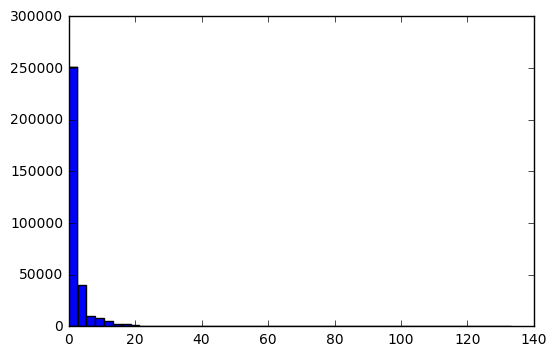

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df['drafted_count'], range=(0, df['drafted_count'].max()),bins=50, color='blue');

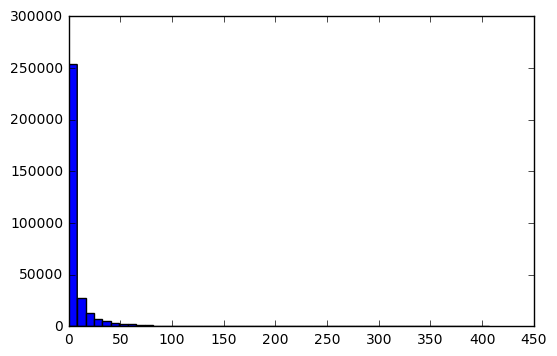

In [15]:
plt.hist(df['posted_count'], range=(0, df['posted_count'].max()),bins=50, color='blue');

In [17]:
df['proposalresourcetypeid'] = df['proposalresourcetypeid'].astype('category')

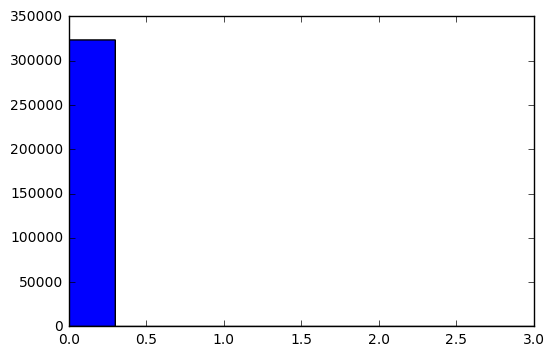

In [21]:
plt.hist(df['proposalresourcetypeid']);

### word frequency

In [22]:
 pd.Series(' '.join(df['essay1']).lower().split()).value_counts()[:100]

to            1324766
and           1285667
the           1004870
students       878498
of             820038
a              792851
my             704565
in             690733
are            669444
they           548773
i              458765
our            415730
is             401151
their          400278
school         376819
have           348967
with           328876
that           320482
for            296521
we             279207
them           203564
as             202071
from           194887
be             173094
many           168063
learning       163078
all            152789
at             151587
on             149607
come           149285
               ...   
through         56131
school.         55740
year            55096
what            53679
students.       53079
you             52836
title           52338
children        50870
best            50708
different       50519
provide         49442
has             49077
diverse         49022
reading         48952
first     

In [23]:
 pd.Series(' '.join(df['essay2']).lower().split()).value_counts()[:100]

to             2016070
the            1671456
and            1571835
students       1065211
a               895910
will            813385
of              811997
in              810272
my              719865
their           572365
they            541357
for             535782
are             483579
that            452406
be              441436
i               437493
with            423091
have            413102
our             409307
is              383445
we              323719
this            284877
as              280650
them            271201
on              266787
these           247308
help            232791
can             216857
learning        199332
it              183331
                ...   
class            75779
math             74441
provide          72894
one              70335
using            70318
time             70111
project          70084
what             68904
create           67977
during           66910
who              66687
am               64913
like       

In [24]:
 pd.Series(' '.join(df['essay3']).lower().split()).value_counts()[:100]

to            264099
the           246484
and           199541
will          140242
students      132102
a             108604
of             95891
in             94970
my             75747
be             74558
their          73471
they           69734
for            67537
with           56822
i              55287
that           54730
are            50567
have           49505
we             45353
our            45021
use            40266
on             38814
as             38338
is             38300
these          36764
them           32785
this           31634
able           30362
can            28934
help           26457
               ...  
time            9579
am              9531
student         9080
other           8983
like            8796
class           8708
one             8656
what            8532
get             8514
small           8509
having          8463
different       8380
love            8074
practice        7790
own             7670
which           7645
want         

In [25]:
 pd.Series(' '.join(df['essay4']).lower().split()).value_counts()[:100]

to             166145
the            128113
and            114100
will           109367
students        85206
a               68360
my              67827
in              62802
of              61414
their           49828
they            47735
be              43327
for             42174
that            40315
this            37302
with            31514
have            31297
i               30458
them            28946
help            28213
our             27892
are             27494
is              26939
these           24337
it              22156
as              20461
more            19383
can             17865
on              17865
project         17838
                ...  
or               6738
through          6729
from             6624
how              6473
get              6354
opportunity      6055
better           5991
become           5858
access           5793
what             5769
students.        5559
time             5493
me               5466
classroom.       5441
only      

In [26]:
 pd.Series(' '.join(df['need_statement']).lower().split()).value_counts()[:100]

students      351792
to            350876
my            344198
need          343320
and           298903
the           142532
a             139899
their         104377
in            103141
for            99846
of             76862
them           54758
our            53222
help           52051
they           47803
that           46892
with           44739
will           41472
learning       36332
books          33530
as             32918
classroom      32252
reading        30839
be             30835
on             30605
can            26862
an             25314
are            23102
math           23058
we             22796
               ...  
about           9518
enhance         9493
read            9440
also            9299
variety         9247
book            8696
such            8687
activities      8565
ipads           8546
practice        8472
items           7951
literacy        7949
through         7904
2               7807
stem            7770
group           7709
improve      

In [31]:
from django.utils.encoding import smart_str, smart_unicode

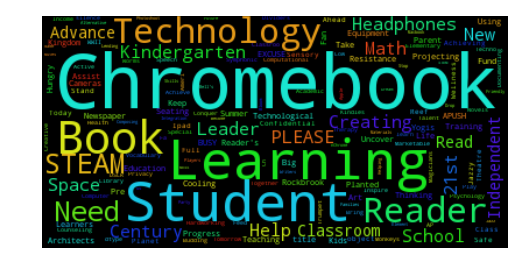

In [33]:
from os import path
from scipy.misc import imread
import random

from wordcloud import WordCloud

text = smart_str(df['title'])
wordcloud = WordCloud(relative_scaling = 1.0).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### relationships

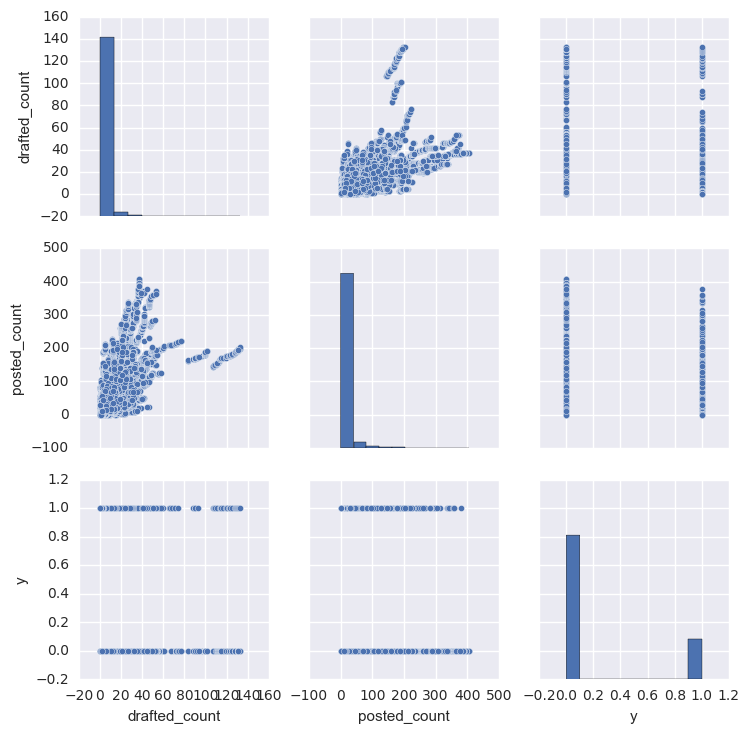

In [45]:
import seaborn as sns
sns.pairplot(df, vars=['drafted_count','posted_count', 'y'])

## summary of distribution
>* For the majority of teachers, this is their first project (posted_count = 0), or they have only posted one project previously (posted_count = 1).
>* Essays 1 and 2, and essays 3 and 4 are very similar. The need statment and title seem to include words that are more unique than those most commonly found in the essays. 
>* The majority of projects are not sent back to draft (y=0)
>* Drafted and posted counts are correlated to a point, and there are some odd outliers. 

<center> **--------------------** </center>

# (3) Test the data

## covariance

In [34]:
x = df['posted_count'].dropna()
y = df['drafted_count'].dropna()
np.cov(m=(x,y))

array([[ 590.07419101,   88.70525768],
       [  88.70525768,   22.93839587]])

# (4) Impact

>* Given this data, I think it'll be tough to get a prediction that is more than 80% accurate. Since only about 20% of projects are ever drafted, the algorithm must be more than 80% accurate, otherwise it's not better than just guessing.
>* The key likely lies in the text data, since the other variables seem to be highly correlated. 
>* I may need to add other features to the original data set, (like project cart information), and create many additional features based on my knowledge of our eligibility criteria.